In [248]:
import os
import json
import keras
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.layers import InputLayer, Dense, Dropout, MaxPool2D, Conv2D, BatchNormalization, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2 as cv
from sklearn.metrics import confusion_matrix

In [77]:
train_dir = '/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train'
val_dir = '/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test'

In [73]:
img_size = 224
batch_size = 32

In [5]:
data_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.1
)

In [268]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=99,
)
    

Found 6799 files belonging to 3 classes.


In [269]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [74]:
class_names = ['angry', 'happy', 'sad']

In [8]:
# train_dataset = train_generator
# val_dataset = val_generator

In [ ]:
for image,label in train_dataset.take(1):
    print(label)

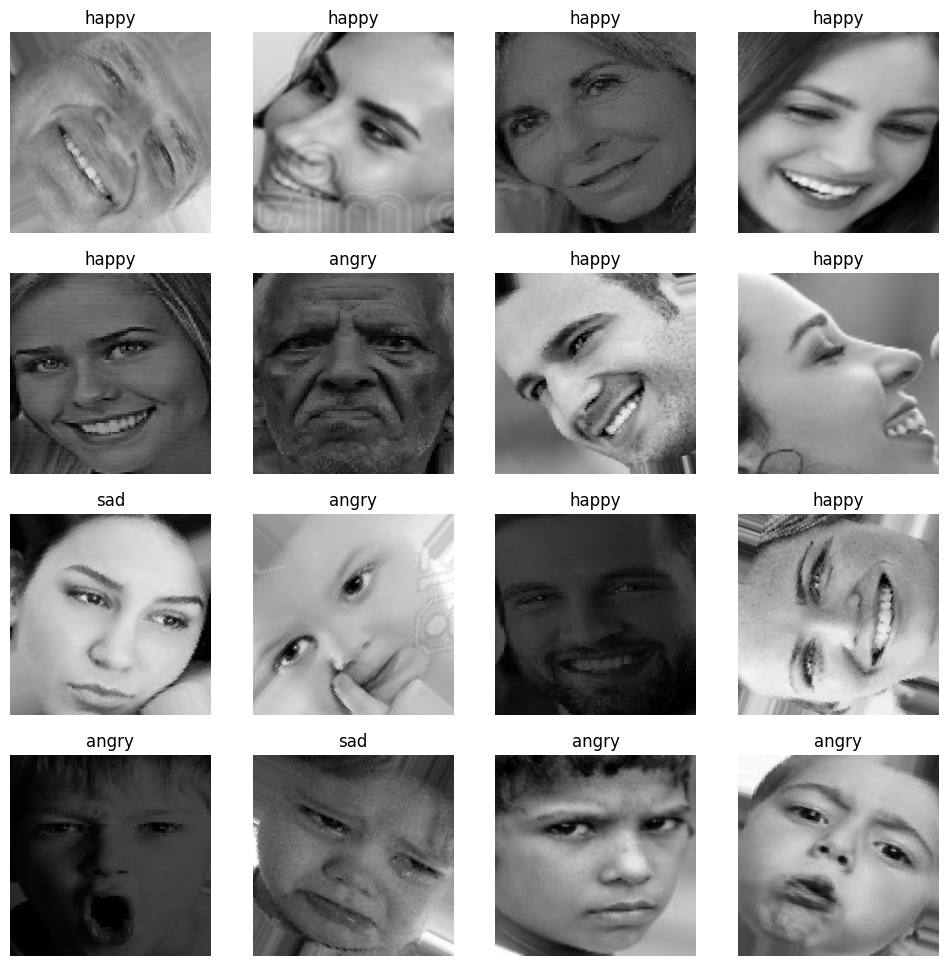

In [90]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(class_names[tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")

In [12]:
resize_rescale_layer = tf.keras.Sequential([
    layers.Resizing(img_size, img_size),
    layers.Rescaling(1./255)
])

In [13]:
# CONFIGURATION = {
#     "BATCH_SIZE": 32,
#     "IM_SIZE": 256,
#     "LEARNING_RATE": 1e-3,
#     "N_EPOCHS": 20,
#     "DROPOUT_RATE": 0.0,
#     "REGULARIZATION_RATE": 0.0,
#     "N_FILTERS": 6,
#     "KERNEL_SIZE": 3,
#     "N_STRIDES": 1,
#     "POOL_SIZE": 2,
#     "N_DENSE_1": 1024,
#     "N_DENSE_2": 128,
#     "NUM_CLASSES": 3,
#     "PATCH_SIZE": 16,
#     "PROJ_DIM": 768,
#     "CLASS_NAMES": ["angry", "happy", "sad"],
# }

In [91]:
model = tf.keras.models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten()) 
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))

model.add(Dense(3, activation='softmax'))


cust_model = model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [92]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,211,139 (99.99 MB)

 Trainable params: 26,211,139 (99.99 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
cust_model.compile(optimizer = 'adam', 
                 loss = 'CategoricalCrossentropy',
                 metrics = ['accuracy', TopKCategoricalAccuracy( k=2, name = 'top_k_accuracy')]
                 )

In [94]:
es_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [95]:
history = cust_model.fit(
     train_dataset,
     epochs = 20,
     validation_data = val_dataset,
     verbose = 1,
    callbacks = [es_callback]
 )

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.4199 - loss: 43.3923 - top_k_accuracy: 0.7710 - val_accuracy: 0.4416 - val_loss: 1.0676 - val_top_k_accuracy: 0.7739
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4429 - loss: 1.0690 - top_k_accuracy: 0.7713 - val_accuracy: 0.4482 - val_loss: 1.0598 - val_top_k_accuracy: 0.7744
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4506 - loss: 1.0664 - top_k_accuracy: 0.7722 - val_accuracy: 0.4631 - val_loss: 1.0520 - val_top_k_accuracy: 0.7744
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4570 - loss: 1.0546 - top_k_accuracy: 0.7758 - val_accuracy: 0.4684 - val_loss: 1.0468 - val_top_k_accuracy: 0.7744
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4693 - loss: 1.0469 - top_k_accuracy: 0.7754 - val_accuracy: 0.4820 - val_loss: 1.0383 - val_top_k_accuracy: 0.7748
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4939 - loss: 1.0

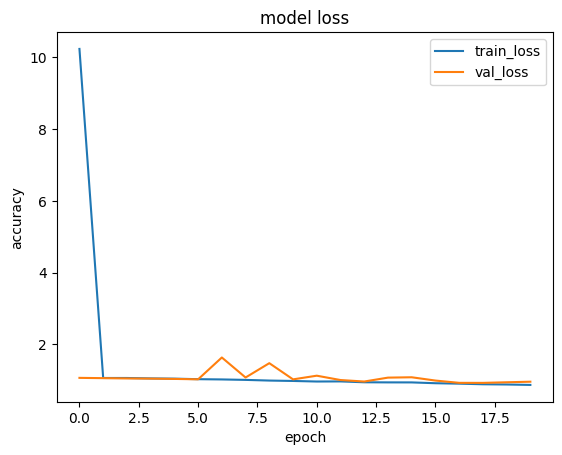

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

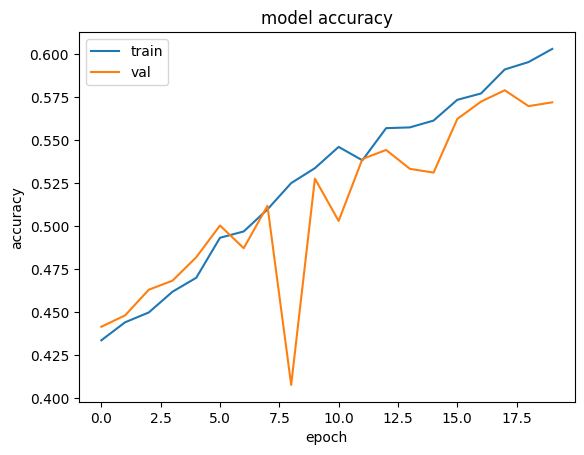

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [98]:
loss,acc,top_k = cust_model.evaluate(val_dataset)
print(loss)
print(acc)
print(top_k)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5568 - loss: 0.9744 - top_k_accuracy: 0.8284
0.960623562335968
0.5719929933547974
0.8305531144142151


In [99]:
test_img = cv.imread('/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg')
test_img = tf.expand_dims(test_img, axis = 0)
test_img.shape

TensorShape([1, 224, 224, 3])

In [101]:
pred = model.predict(test_img)
pred_label = [np.argmax(i) for i in pred]
for i in pred_label:
    print(class_names[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
sad


In [102]:
image,label = next(train_generator)


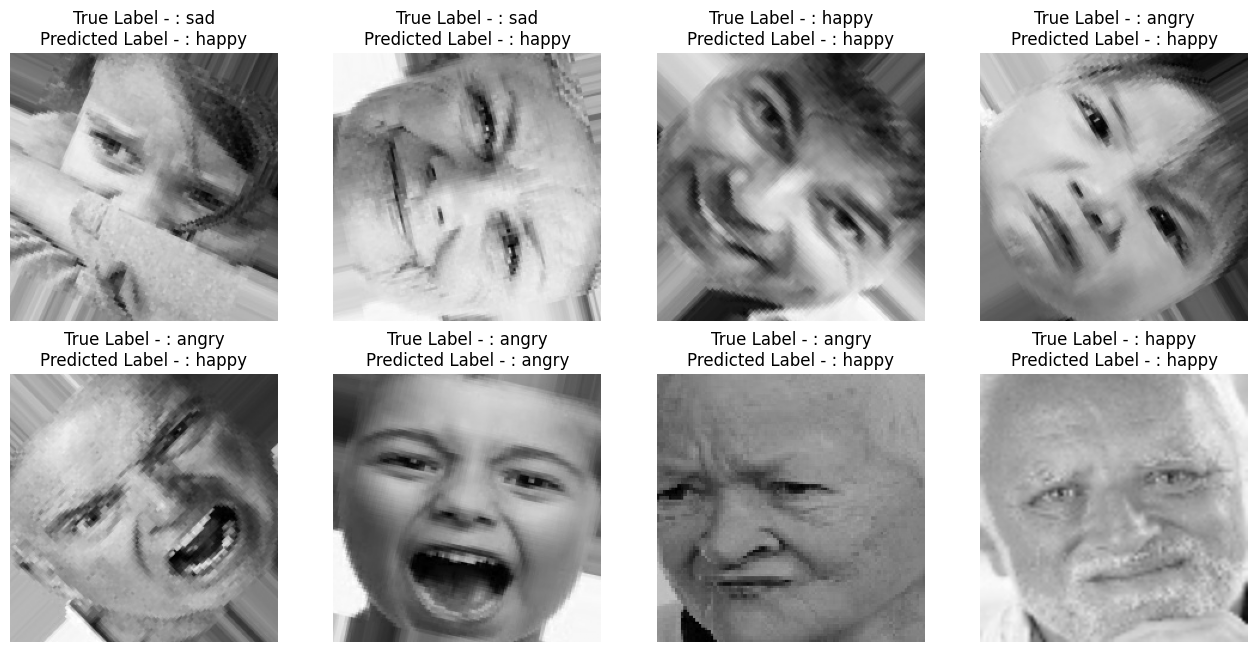

In [111]:
plt.figure(figsize = (16,16))

for images, labels in val_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)

        plt.title("True Label - : " +class_names[tf.argmax(labels[i], axis = -1).numpy()] 
              + "\n" + "Predicted Label - : " 
              + class_names[int(tf.argmax(model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
        plt.axis("off")
     

192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step


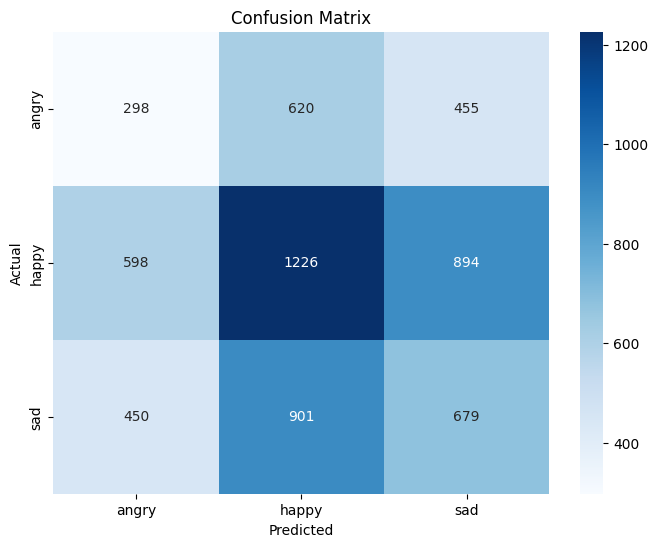

In [42]:
import seaborn as sns

Y_pred = model.predict(train_dataset)
y_pred = np.argmax(Y_pred, axis=1)  

y_true = train_generator.classes  
class_labels = list(train_generator.class_indices.keys())  

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## Records ##

In [48]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

In [113]:
train_dataset_un = train_dataset.unbatch()

In [115]:
val_dataset_un = val_dataset.unbatch()

In [240]:
import tensorflow as tf

def image_encoder(image, label):
    # Ensure the image is in the correct dtype and range
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)  # Convert to uint8
    image_jpeg = tf.io.encode_jpeg(image)  # Encode image to JPEG format
    return image_jpeg, tf.argmax(label)  # Assuming label is one-hot encoded

def create_examples(image, label):
    # Create TensorFlow Example
    bytes_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[image]))
    int_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))  # Convert label to scalar

    example = tf.train.Example(features=tf.train.Features(feature={
        'images': bytes_feature,
        'labels': int_feature,
    }))
    return example.SerializeToString()

# Prepare the dataset
encoded_dataset = train_dataset_un.map(image_encoder)

# Define path for TFRecord files
path = '/kaggle/working/tfrecords/shard_{:02d}.tfrecord'
shards = 5  # Define number of shards

for shard_number in range(shards):
    shard_dataset = encoded_dataset.shard(shards, shard_number).as_numpy_iterator()

    with tf.io.TFRecordWriter(path.format(shard_number)) as file_writer:
        for encoded_image, encoded_label in shard_dataset:
            file_writer.write(create_examples(encoded_image, encoded_label))

# Reading back the dataset
recon_dataset = tf.data.TFRecordDataset(filenames=[path.format(p) for p in range(shards)])

# Parse the TFRecords to verify
def parse_example(example):
    feature_description = {
        'images': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['images'], channels=3)  # Decode image
    label = example['labels']
    return image, label

# Iterate over the reconstructed dataset to check the images and labels
for raw_record in recon_dataset.take(5):
    image, label = parse_example(raw_record)
    print("Image shape:", image.shape)
    print("Label:", label)


Image shape: (224, 224, 3)
Label: 1
Image shape: (224, 224, 3)
Label: 1
Image shape: (224, 224, 3)
Label: 1
Image shape: (224, 224, 3)
Label: 1
Image shape: (224, 224, 3)
Label: 1


In [241]:
for raw_record in recon_dataset.take(5):
    image, label = parse_example(raw_record)
    print("Image shape:", image)
    print("Label:", label)

Image shape: tf.Tensor(
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]], shape=(224, 224, 3), dtype=uint8)
Label: tf.Tensor(1, shape=(), dtype=int64)
Image shape: tf.Tensor(
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [2

In [224]:
def create_example(image, label):
    
    bytes_feature = Feature(
    bytes_list=BytesList(value=[image]))

    int_feature = Feature(
    int64_list=Int64List(value=[label]))

    example = Example(
    features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
    }))
  
    return example.SerializeToString()

In [225]:
from pathlib import Path
Path('/kaggle/working/tfrecords').mkdir(parents=True, exist_ok=True)

In [226]:
shards = 10
path = '/kaggle/working/tfrecords/shards_{:02d}.tfrecord'

In [227]:
import tensorflow as tf

def image_encoder(image, label):
    
    image = tf.image.convert_image_dtype(image, dtype = tf.uint8)
    image_jpeg = tf.io.encode_jpeg(image)
    
    return image_jpeg, tf.argmax(label)


In [228]:
encoded_dataset = train_dataset_un.map(image_encoder)

In [229]:
for shard_number in range(shards):
    shard_dataset = (encoded_dataset.shard(shards,shard_number).as_numpy_iterator())

    with tf.io.TFRecordWriter(path.format(shard_number)) as file_writer:
        for encoded_image, encoded_label in shard_dataset:
            file_writer.write(create_examples(encoded_image,encoded_label))

In [232]:
l = [path.format(p) for p in range(shards)]
print(l)

['/kaggle/working/tfrecords/shards_00.tfrecord', '/kaggle/working/tfrecords/shards_01.tfrecord', '/kaggle/working/tfrecords/shards_02.tfrecord', '/kaggle/working/tfrecords/shards_03.tfrecord', '/kaggle/working/tfrecords/shards_04.tfrecord', '/kaggle/working/tfrecords/shards_05.tfrecord', '/kaggle/working/tfrecords/shards_06.tfrecord', '/kaggle/working/tfrecords/shards_07.tfrecord', '/kaggle/working/tfrecords/shards_08.tfrecord', '/kaggle/working/tfrecords/shards_09.tfrecord']


In [195]:
recon_dataset = tf.data.TFRecordDataset(filenames = [path.format(p) for p in range(shards)])

In [202]:
def parse(example):
    feature_description = {
        'images' : tf.io.FixedLenFeature([], tf.string),
        'labels' : tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example['images'] = tf.image.convert_image_dtype(tf.io.decode_jpeg(example['images'], channels = 3), dtype = tf.float32)
    
    return example['images'], example['labels']

In [203]:
parsed_dataset = (recon_dataset.map(parse).batch(batch_size).prefetch(tf.data.AUTOTUNE))

In [204]:
print(parsed_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [235]:
for i in parsed_dataset.take(1):
    print(i)
     

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        

In [191]:
cust_model.compile(optimizer = 'adam', 
                 loss = 'SparseCategoricalCrossentropy',
                 metrics = ['accuracy']
                 )

In [ ]:
history = cust_model.fit(
     parsed_dataset,
     epochs = 20,
     #validation_data = val_dataset,
     verbose = 1,
    callbacks = [es_callback]
 )

## Tranfer Learning ##

In [244]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

In [245]:
backbone.trainable = Falsea

In [261]:
model = tf.keras.Sequential([
    InputLayer(shape = (img_size, img_size, 3)),
    backbone,
    layers.GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu'),
    layers.BatchNormalization(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(3 , activation = 'softmax')
])

In [262]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │     1,836,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

In [263]:
Path('/kaggle/working/best_weights.keras').mkdir(parents=True, exist_ok=True)

In [264]:
checkpoint = ModelCheckpoint('/kaggle/working/best_weights.keras',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            verbose = 1,
                            save_best_only=True)

In [265]:
model.compile(optimizer = 'adam', 
                 loss = 'CategoricalCrossentropy',
                 metrics = ['accuracy', TopKCategoricalAccuracy( k=2, name = 'top_k_accuracy')]
                 )

In [273]:
history = cust_model.fit(
     train_dataset,
     epochs = 20,
     validation_data = val_dataset,
     verbose = 1,
     callbacks = [checkpoint]
 )

Epoch 1/20


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 3), output.shape=(None, 3)